In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_colwidth',300)


In [2]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict



In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler,OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_columns',100)

In [4]:
fpath = pd.read_csv('Data-NLP/processed_data.csv')
df = fpath
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating,lower_text,tokens,target,spacy_lemmas,length
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The ...",7.0,"this is a fine piece of cinema from wong kar-wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. we start with two couples who move into a new building. one a newspaper man with his wife, the other a business executive and his wife. the ...","['this', 'is', 'a', 'fine', 'piece', 'of', 'cinema', 'from', 'wong', 'kar-wai', 'that', 'tells', 'us', 'a', 'story', 'of', 'two', 'people', 'whom', 'circumstance', 'throws', 'together', '-', 'but', 'not', 'in', 'a', 'way', 'you', 'might', 'expect.', 'we', 'start', 'with', 'two', 'couples', 'who'...",NaN,"['fine', 'piece', 'cinema', 'wong', 'kar', 'wai', 'tell', 'story', 'people', 'circumstance', 'throw', 'way', 'expect', 'start', 'couple', 'new', 'building', 'newspaper', 'man', 'wife', 'business', 'executive', 'wife', 'businessman', 'rarely', 'home', 'journalist', 'wife', 'leave', 'increasingly'...",266
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,"a guilty pleasure for me personally, as i love both 'the great escape' and most of the works i have seen, over the years, from this rightfully-esteemed british animation company. highly recommended both for children and for adults who enjoy animation.","['a', 'guilty', 'pleasure', 'for', 'me', 'personally,', 'as', 'i', 'love', 'both', ""'the"", 'great', ""escape'"", 'and', 'most', 'of', 'the', 'works', 'i', 'have', 'seen,', 'over', 'the', 'years,', 'from', 'this', 'rightfully-esteemed', 'british', 'animation', 'company.', 'highly', 'recommended', '...",high-rating,"['guilty', 'pleasure', 'personally', 'love', 'great', 'escape', 'work', 'see', 'year', 'rightfully', 'esteem', 'british', 'animation', 'company', 'highly', 'recommend', 'child', 'adult', 'enjoy', 'animation']",41
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I liked it. Would personally recommend you give it a ...",6.0,"made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. it's maybe not as great as i remember thinking it was when i was a little kid, but it still holds up to some degree.\r\n\r\n_final rating:★★★ - i liked it. would personally recommend you give it a ...","['made', 'my', 'roommate', 'who', 'hates', 'stop-motion', 'animation', 'watched', 'this', 'in', '2018', 'and', 'even', 'he', 'had', 'a', 'good', 'time.', ""it's"", 'maybe', 'not', 'as', 'great', 'as', 'i', 'remember', 'thinking', 'it', 'was', 'when', 'i', 'was', 'a', 'little', 'kid,', 'but', 'it',...",NaN,"['roommate', 'hate', 'stop', 'motion', 'animation', 'watch', '2018', 'good', 'time', 'maybe', 'great', 'remember', 'think', 'little', 'kid', 'hold', 'degree', 'final', 'rating', '★', '★', '★', 'like', 'personally', 'recommend']",57
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the film, it's a very well developed

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8650 entries, 0 to 8649
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review_id       8650 non-null   object 
 1   movie_id        8650 non-null   int64  
 2   imdb_id         8650 non-null   object 
 3   original_title  8650 non-null   object 
 4   review          8650 non-null   object 
 5   rating          7454 non-null   float64
 6   lower_text      8650 non-null   object 
 7   tokens          8650 non-null   object 
 8   target          2419 non-null   object 
 9   spacy_lemmas    8650 non-null   object 
 10  length          8650 non-null   int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 743.5+ KB


In [6]:
df['rating'].value_counts()

7.0     1576
6.0     1386
8.0     1259
5.0      732
9.0      616
10.0     564
4.0      514
1.0      284
3.0      254
2.0      153
7.5       27
8.5       23
6.5       22
9.5       15
0.5       10
5.5        6
3.5        4
4.5        4
1.5        3
2.5        2
Name: rating, dtype: int64

In [7]:
df = df.dropna()

In [8]:
# Define x and y
X =df['review']
y = df['target']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [10]:
# Imports for pipeline
import numpy as np
import pandas as pd
from sklearn import set_config
set_config(transform_output='pandas')


In [11]:
# instantiate a vectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

CountVectorizer()

In [12]:
# Fit it on the data 
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

 high-rating       0.98      0.96      0.97       896
  low-rating       0.97      0.98      0.98       918

    accuracy                           0.97      1814
   macro avg       0.97      0.97      0.97      1814
weighted avg       0.97      0.97      0.97      1814



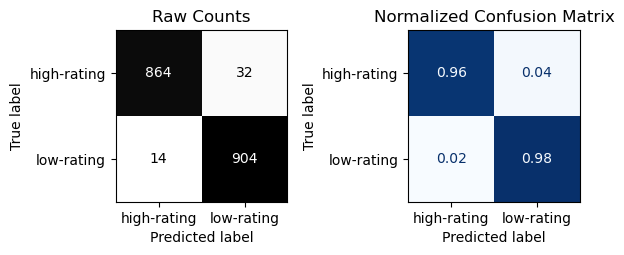


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

 high-rating       0.89      0.86      0.88       299
  low-rating       0.87      0.90      0.88       306

    accuracy                           0.88       605
   macro avg       0.88      0.88      0.88       605
weighted avg       0.88      0.88      0.88       605



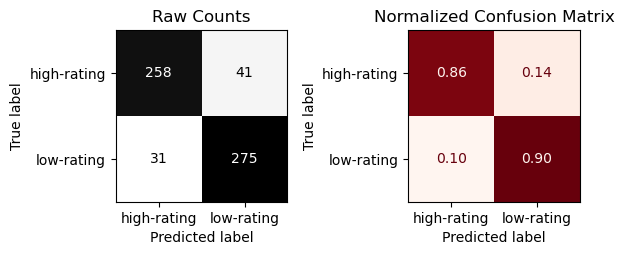

In [13]:
# Instantiate mdoel
clf_nb = MultinomialNB()
# Fit on training data
clf_nb.fit(X_train_vec, y_train)
# Transform, predict, and evaluate with custom function
evaluate_classification(clf_nb, X_train_vec,y_train, X_test_vec, y_test)

In [14]:
clf_nb.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}

In [15]:
# Params tuning
# Define param grid
params={'alpha': [0.001, 0.1, .5, 1, 1.5, 10, 100],
        'fit_prior': [True, False]}


In [16]:
# Instantiate Grid Search CV 
from sklearn.model_selection import GridSearchCV
#Instantiate GridSearchCV
grid_search = GridSearchCV(clf_nb, param_grid=params, n_jobs = -1, verbose = 2)
# Fit the Gridsearch on the training data
grid_search.fit(X_train_vec, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.1, 0.5, 1, 1.5, 10, 100],
                         'fit_prior': [True, False]},
             verbose=2)

In [17]:
# Obtain the best combination directly
grid_search.best_params_


{'alpha': 1.5, 'fit_prior': True}

# Count Vectorizor Tuning

In [18]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
pd.set_option('display.max_colwidth',300)


In [19]:
# Create a pipeline with a vectorizer and classification model.
clf_pipe = Pipeline([('vectorizer', CountVectorizer()),
                     ('clf',MultinomialNB())])

In [20]:
clf_pipe.get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()), ('clf', MultinomialNB())],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'clf': MultinomialNB(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'clf__alpha': 1.0,
 'clf__class_prior': None,
 'clf__fit_prior': True,
 'clf__force_alpha': 'warn'}

In [21]:
# Param Grid
param_grid = {
    "vectorizer__max_df": [ 0.75, 0.85, 0.95],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 500, 1000, 2000],
    "vectorizer__ngram_range": [(1, 1), (1, 2)],
    "vectorizer__stop_words": [None,'english'],
    "clf__alpha": [.5, 1]
}

In [22]:
%%time
# Create grid search
grid_search = GridSearchCV(clf_pipe, param_grid, cv=3,verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 288 candidates, totalling 864 fits
CPU times: total: 3.69 s
Wall time: 25.7 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.5, 1],
                         'vectorizer__max_df': [0.75, 0.85, 0.95],
                         'vectorizer__max_features': [None, 500, 1000, 2000],
                         'vectorizer__min_df': [2, 3, 4],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)],
                         'vectorizer__stop_words': [None, 'english']},
             verbose=2)

In [23]:
# Get Params
grid_search.best_params_

{'clf__alpha': 1,
 'vectorizer__max_df': 0.75,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 2,
 'vectorizer__ngram_range': (1, 2),
 'vectorizer__stop_words': None}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

 high-rating       0.99      0.99      0.99       896
  low-rating       0.99      0.99      0.99       918

    accuracy                           0.99      1814
   macro avg       0.99      0.99      0.99      1814
weighted avg       0.99      0.99      0.99      1814



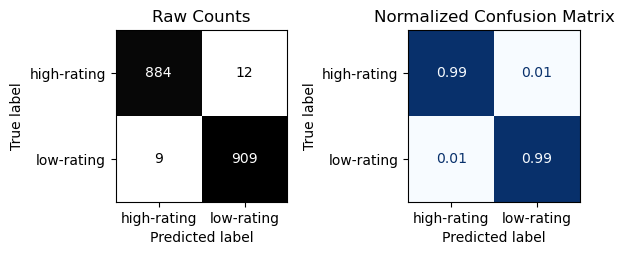


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

 high-rating       0.90      0.89      0.90       299
  low-rating       0.89      0.91      0.90       306

    accuracy                           0.90       605
   macro avg       0.90      0.90      0.90       605
weighted avg       0.90      0.90      0.90       605



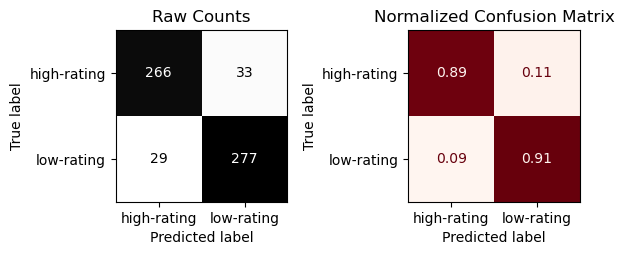

In [24]:
# Now define the best version of the model
best_model = grid_search.best_estimator_

# Predict and Evaluate with the custom function
evaluate_classification(best_model, X_train, y_train, X_test, y_test)


In [25]:
import json, joblib
FILEPATHS_FILE = 'config/filepaths.json'
with open(FILEPATHS_FILE) as f:
    FPATHS = json.load(f)

In [26]:
FPATHS

{'data': {'raw': {'full': 'Data-NLP/movie_reviews_v2.csv',
   'eda': 'Data-NLP/processed_data.csv'},
  'ml': {'train': 'Data-NLP/train.joblib',
   'test': 'Data-NLP/test.joblib',
   'label_encoder': 'Data-NLP/label-encoder.joblib',
   'target_lookup': 'Data-NLP/target-lookup-dict.joblib'}},
 'models': {'clf': 'Models/clf_pipe.joblib'}}

In [27]:
# Save training data
fpath_train = FPATHS['data']['ml']['train']
joblib.dump([X_train, y_train], fpath_train)
# Save testing data
fpath_test = FPATHS['data']['ml']['test']
joblib.dump([X_test, y_test], fpath_test)

['Data-NLP/test.joblib']

In [28]:
fpath_rf_pipe = FPATHS['models']['clf']
joblib.dump(best_model, fpath_rf_pipe)

['Models/clf_pipe.joblib']

# Summary
- The best params were the following:
- {'clf__alpha': 1,
 'vectorizer__max_df': 0.75,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 2,
 'vectorizer__ngram_range': (1, 2),
 'vectorizer__stop_words': 
- The best estimator performed at a precision of 99 on the Training Data and at a precision of 90 on the Testing Data.None}

# Tensorflow
- Keras Tuner

In [29]:
import tensorflow as tf
import numpy as np
# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

In [30]:
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)

In [31]:
%load_ext autoreload
%autoreload 2

In [32]:
# Define X and y
X = df['review']
y_string= df['target']
# Instantiate the LabelEncoder
encoder = LabelEncoder()
# Fit and Transform the strings into integers
y = pd.Series(encoder.fit_transform(y_string))
y.value_counts()

1    1224
0    1195
dtype: int64

In [33]:
df['length'].max()

4054

In [34]:
# Convert to Dataset Object
ds = tf.data.Dataset.from_tensor_slices((X, y))
# Shuffle dataset
ds = ds.shuffle(buffer_size=len(ds),reshuffle_each_iteration=False)

In [35]:
import math
BATCH_SIZE =32
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )
# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)
print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	1693 samples 	(53 batches)
    - val:  	483 samples 	(16 batches)
    - test: 	243 samples 	(8 batches)


In [36]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)
# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)
# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)
# Confirm len of train_ds
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 53 training batches.
 There are 16 validation batches.
 There are 8 testing batches.


In [37]:
from pprint import pprint
def make_text_vectorization_layer(train_ds,  max_tokens=None, 
                                  split='whitespace',
                                  standardize="lower_and_strip_punctuation",
                                  output_mode="int",
                                  output_sequence_length=None,
                                  ngrams=None, pad_to_max_tokens=False,
                                  verbose=True,
                                  **kwargs,
                                 ):
    # Build the text vectorization layer
    text_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens,
        standardize=standardize, 
        output_mode=output_mode,
        output_sequence_length=output_sequence_length,
        **kwargs
    )
    # Get just the text from the training data
    if isinstance(train_ds, (np.ndarray, list, tuple, pd.Series)):
        ds_texts = train_ds
    else:
        try:
            ds_texts = train_ds.map(lambda x, y: x )
        except:
            ds_texts = train_ds
            
    # Fit the layer on the training texts
    text_vectorizer.adapt(ds_texts)
    
    
    if verbose:
        # Print the params
        print( "\ntf.keras.layers.TextVectorization(" )
        config = text_vectorizer.get_config()
        pprint(config,indent=4)
        print(")")
               
    # SAVING VOCAB FOR LATER
    # Getting list of vocab 
    vocab = text_vectorizer.get_vocabulary()
    # Save dictionaries to look up words from ints 
    int_to_str  = {idx:word for idx, word in enumerate(vocab)}
    
    return text_vectorizer, int_to_str

In [38]:
# Define sequence length as a variable for future use
SEQUENCE_LENGTH = 4054
# Define vectorizer layer. Use the custom function to build and fit the vectorizer before using it in model
vectorizer, lookup = make_text_vectorization_layer(train_ds, output_mode='int',output_sequence_length=SEQUENCE_LENGTH, verbose=True)
# Check the size of the vocabulary
VOCAB_SIZE = len(vectorizer.get_vocabulary())


tf.keras.layers.TextVectorization(
{   'batch_input_shape': (None,),
    'dtype': 'string',
    'encoding': 'utf-8',
    'idf_weights': None,
    'max_tokens': None,
    'name': 'text_vectorization',
    'ngrams': None,
    'output_mode': 'int',
    'output_sequence_length': 4054,
    'pad_to_max_tokens': False,
    'ragged': False,
    'sparse': False,
    'split': 'whitespace',
    'standardize': 'lower_and_strip_punctuation',
    'trainable': True,
    'vocabulary': None,
    'vocabulary_size': 24923}
)


In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers

In [40]:
# Define classes variable
classes = y.unique()
classes

array([0, 1])

In [41]:
def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict

In [42]:
def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])
    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()
    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):
        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]
        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass
        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)
    # Adjust subplots and show
    fig.tight_layout()
    plt.show()

In [43]:
def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs

In [44]:
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

In [45]:
def build_gru_model_bi_pool(text_vectorization_layer):
    
    gru_model_bi_pool = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                      output_dim=EMBED_DIM,
                      input_length=SEQUENCE_LENGTH)])
        
    # Add bidirectional component to GRU layer 
    gru_model_bi_pool.add(layers.Bidirectional(layers.GRU(64, return_sequences = True)))
    gru_model_bi_pool.add(layers.Dropout(.2))
    gru_model_bi_pool.add(layers.Bidirectional(layers.GRU(64, return_sequences = True)))
    # Add a pooling layer *new
    gru_model_bi_pool.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    gru_model_bi_pool.add(layers.Dense(len(classes), activation='softmax'))
                     
    optimizer = optimizers.legacy.Adam()
    gru_model_bi_pool.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model_bi_pool.summary()
    return gru_model_bi_pool
#Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]
EMBED_DIM = 100
#Build the model
model = build_gru_model_bi_pool(vectorizer)
# Fit the model
EPOCHS = 5#30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Evaluate the model
results = evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 4054)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 4054, 100)         2492300   
                                                                 
 bidirectional (Bidirectiona  (None, 4054, 128)        63744     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 4054, 128)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4054, 128)        74496     
 nal)                                                            
                                                        

KeyboardInterrupt: 

In [ ]:
# Saving model in tf format 
fpath_model = "Models/gru/" # Filename is a folder 
tf.keras.models.save_model(model, fpath_model, save_format='tf')

In [ ]:
# Saving the training dataset
fpath_save_train_ds = "Data-NLP/tf/train/"
# train_ds.save(path=fpath_save_train_ds)
tf.data.Dataset.save(train_ds, fpath_save_train_ds)
# Saving the test dataset
fpath_save_test_ds = "Data-NLP/tf/test/"
# test_ds.save(path=fpath_save_test_ds)
tf.data.Dataset.save(test_ds, fpath_save_test_ds)

